# Transfer Learning

## Transfer resnet weights which is trained with ImageNet for transfer learning

In [14]:
#prepare images

import os 

try:
  os.mkdir("images")
  os.mkdir("images/dogs")
  os.mkdir("images/cats")
except:
  pass

!wget https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg -P images/dogs
!wget https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg -P images/dogs
  
!wget https://www.catster.com/wp-content/uploads/2018/05/A-gray-cat-crying-looking-upset.jpg -P images/cats
!wget https://www.scarymommy.com/wp-content/uploads/2018/01/c1.jpg?w=700 -P images/cats

--2020-12-13 12:43:00--  https://i.kinja-img.com/gawker-media/image/upload/s--WFkXeene--/c_scale,f_auto,fl_progressive,q_80,w_800/ol9ceoqxidudap8owlwn.jpg
Resolving i.kinja-img.com (i.kinja-img.com)... 151.101.66.166, 151.101.130.166, 151.101.194.166, ...
Connecting to i.kinja-img.com (i.kinja-img.com)|151.101.66.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32099 (31K) [image/jpeg]
Saving to: ‘images/dogs/ol9ceoqxidudap8owlwn.jpg.1’

ol9ceoqxidudap8owlw 100%[===================>]  31.35K  --.-KB/s    in 0.02s   

2020-12-13 12:43:01 (1.82 MB/s) - ‘images/dogs/ol9ceoqxidudap8owlwn.jpg.1’ saved [32099/32099]

--2020-12-13 12:43:01--  https://www.rspcansw.org.au/wp-content/uploads/2017/08/50_a-feature_dogs-and-puppies_mobile.jpg
Resolving www.rspcansw.org.au (www.rspcansw.org.au)... 101.0.86.38
Connecting to www.rspcansw.org.au (www.rspcansw.org.au)|101.0.86.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130940 (128K) [image/j

In [16]:
# import modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [28]:
# set hyperparameters
batch_size = 2
learning_rate = 0.001
num_epoch = 100
num_category = 2

In [19]:
# Input pipeline from a folder containing multiple folders of images
# we can check the classes, class_to_idx, and filename with idx

img_dir = "./images"
img_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.RandomSizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            ]))

print(img_data.classes)
print(img_data.class_to_idx)
print(img_data.imgs)

['cats', 'dogs']
{'cats': 0, 'dogs': 1}
[('./images/cats/A-gray-cat-crying-looking-upset.jpg', 0), ('./images/dogs/50_a-feature_dogs-and-puppies_mobile.jpg', 1), ('./images/dogs/ol9ceoqxidudap8owlwn.jpg', 1)]


/home/ubuntu18/anaconda3/envs/torch1.5/lib/python3.6/site-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


In [20]:
# load data
train_loader = DataLoader(img_data, batch_size=batch_size,
                            shuffle=True, num_workers=2,drop_last=True)

for img,label in train_loader:
    print(img.size())
    print(label)

torch.Size([2, 3, 224, 224])
tensor([1, 0])


In [22]:
resnet = models.resnet50(pretrained=True)
# print layer list
for name, module in resnet.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


## Building transfered architecture

In [23]:
import torch
import torch.nn as nn

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:-1])
        self.layer1 = nn.Sequential(
            nn.Linear(2048, 500),
            nn.BatchNorm1d(500),
            nn.ReLU(),
            nn.Linear(500, num_category),
            nn.ReLU()
        )
        
    def forward(self, x):
        out = self.layer0(x)
        out = out.view(batch_size, -1)
        out = self.layer1(out)
        return out

In [24]:
print(list(resnet.children())[0:-1])

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tr

In [25]:
print(*list(resnet.children())[0:-1])   # unpacking the list

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) ReLU(inplace=True) MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False) Sequential(
  (0): Bottleneck(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, t

In [26]:
# define parameters which will be update
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Resnet().to(device)

for params in model.layer0.parameters():
    params.require_grad = False

for params in model.layer1.parameters():
    params.require_grad = True


cuda:0


In [27]:
# check model
for m in model.children():
    print(m)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [33]:
# loss, optimizer, train, test
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate)

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x = image.to(device)
        y_ = label.to(device)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
    if i % 10 == 0 :
        print(loss)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for image, label in train_loader:  # Since we don't have test set, we use train_loader to use train dataset
        x = image.to(device)
        y_ = label.to(device)
        
        output = model.forward(x)
        _, output_index = torch.max(output, 1)
        print('-----output_index-----')
        print(output_index)
        print(y_)
        print('-----label.size-----')
        print(label.size(0))
        
        
        total += label.size(0)
        correct += (output_index == y_).sum().float()
        
    print('Accuracy of Train Data : {}'.format(100*correct/total))

tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(9.5475, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(2.9087e-05, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward>)
tensor(0., device='cuda:0', grad_fn=<NllLossBackward>)
-----output_index-----
tensor([1, 0], device='cuda:0')
tensor([1, 0], device='cuda:0')
-----label.size-----
2
Accuracy of Train Data : 100.0


# Style Transfer

In [34]:
# download images
import os 

try:
  os.mkdir("images")
  os.mkdir("images/content")
  os.mkdir("images/style")
except:
  pass

!wget https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg -P images/content
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -P images/style

--2020-12-13 13:33:49--  https://upload.wikimedia.org/wikipedia/commons/0/00/Tuebingen_Neckarfront.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406531 (397K) [image/jpeg]
Saving to: ‘images/content/Tuebingen_Neckarfront.jpg’

Tuebingen_Neckarfro 100%[===================>] 397.00K  1.15MB/s    in 0.3s    

2020-12-13 13:33:50 (1.15 MB/s) - ‘images/content/Tuebingen_Neckarfront.jpg’ saved [406531/406531]

--2020-12-13 13:33:50--  https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP requ

In [36]:
# import modules and set hyperparameters
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import torch.utils.data as data
import torchvision.models as models
import torchvision.utils as v_utils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

# define which layer will be used to transfer contents
content_layer_num = 1
image_size = 512
epoch = 5000

In [37]:
# directory of style and content
content_dir = "./images/content/Tuebingen_Neckarfront.jpg"
style_dir = "./images/style/1280px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"

In [39]:
# Since resnet50 is pre-trained with ImageNet, normalize input image accroding to ImageNet
def image_preprocess(img_dir):
    img = Image.open(img_dir)
    transform = transforms.Compose([
                    transforms.Resize(image_size),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], 
                                         std=[1,1,1]),
                ])
    img = transform(img).view((-1,3,image_size,image_size))
    return img

In [40]:
# post process the output of network 
# set image range from 0 to 1
def image_postprocess(tensor):
    transform = transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], 
                                     std=[1,1,1])
    img = transform(tensor.clone())
    img = img.clamp(0,1)
    img = torch.transpose(img,0,1)
    img = torch.transpose(img,1,2)
    return img

In [46]:
resnet = models.resnet50(pretrained = True)
for name, module in resnet.named_children():
    print(name)

class Resnet(nn.Module):
    def __init__(self):
        super(Resnet, self).__init__()
        self.layer0 = nn.Sequential(*list(resnet.children())[0:1])
        self.layer1 = nn.Sequential(*list(resnet.children())[1:4])
        self.layer2 = nn.Sequential(*list(resnet.children())[4:5])
        self.layer3 = nn.Sequential(*list(resnet.children())[5:6])
        self.layer4 = nn.Sequential(*list(resnet.children())[6:7])
        self.layer5 = nn.Sequential(*list(resnet.children())[7:8])
        
    def forward(self, x):
        out_0 = self.layer0(x)
        out_1 = self.layer1(out_0)
        out_2 = self.layer2(out_1)
        out_3 = self.layer3(out_2)
        out_4 = self.layer4(out_3)
        out_5 = self.layer5(out_4)
        
        return out_0, out_1, out_2, out_3, out_4, out_5
    

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

resnet = Resnet().to(device)
for param in resnet.parameters():
    param.requires_grad = False
    
#calculate Gram matrix and use it for computing loss
# [batch,channel,height,width] -> [b,c,h*w]
# [b,c,h*w] x [b,h*w,c] = [b,c,c]
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        
        return G
    
class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        
        return out

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
cuda:0


False False True


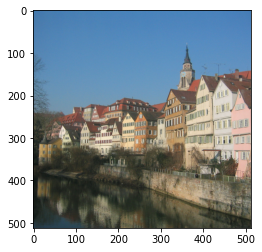

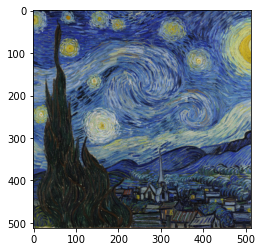

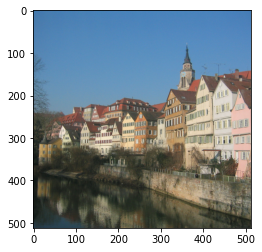

In [48]:
content = image_preprocess(content_dir).to(device)
style = image_preprocess(style_dir).to(device)
generated = content.clone().requires_grad_().to(device)

print(content.requires_grad,style.requires_grad,generated.requires_grad)

# visualize content, style, generated

plt.imshow(image_postprocess(content[0].cpu()))
plt.show()

plt.imshow(image_postprocess(style[0].cpu()))
plt.show()

gen_img = image_postprocess(generated[0].cpu()).data.numpy()
plt.imshow(gen_img)
plt.show()

In [49]:
style_target = list(GramMatrix().to(device)(i) for i in resnet(style))
content_target = resnet(content)[content_layer_num]
style_weight = [1/n**2 for n in [64,64,256,512,1024,2048]]

optimizer = optim.LBFGS([generated])

iteration = [0]
while iteration[0] < epoch:
    
    def closure():
        optimizer.zero_grad()
        out = resnet(generated)
        style_loss = [GramMSELoss().to(device)(out[i],style_target[i])*style_weight[i] for i in range(len(style_target))]
        content_loss = nn.MSELoss().to(device)(out[content_layer_num],content_target)
        total_loss = 1000*sum(style_loss) + content_loss
        total_loss.backward()
        if iteration[0] % 100 == 0:
            print(total_loss)
        iteration[0] += 1
        
        return total_loss
    
    optimizer.step(closure)

tensor(1507036.6250, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.8219, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.3517, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.7038, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1.4196, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9187, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.6588, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.5099, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4105, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3030, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2434, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2228, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2066, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1935, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1825, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1736, device='cuda:0', grad_fn=<

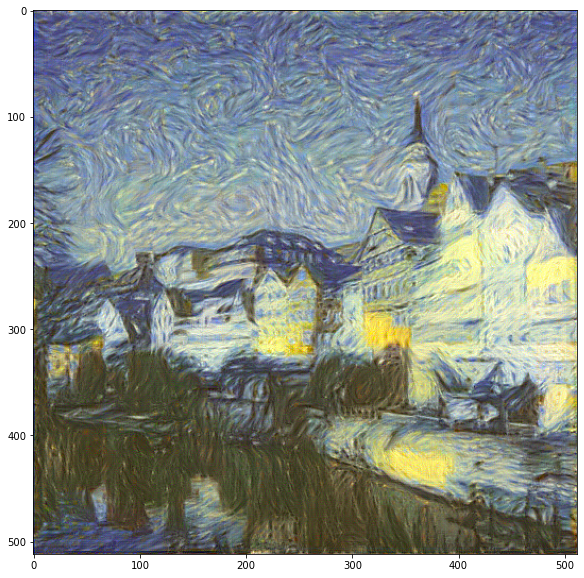

In [50]:
# plot generated image
gen_img = image_postprocess(generated[0].cpu()).data.numpy()

plt.figure(figsize=(10,10))
plt.imshow(gen_img)
plt.show()